In [1]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import glob
import re
import os
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import albumentations as A

In [ ]:
from torchvision import transforms
import torchvision.datasets as datasets

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
path2img = "/media/brats/DRIVE1/akansh/lung-seg/data/images/"
path2mask = "/media/brats/DRIVE1/akansh/lung-seg/data/masks/"

In [3]:
class LungDataset(Dataset):
    
    def __init__(self, img_dir, mask_dir, transform = None):
        
        self.img_dir = [os.path.join(img_dir,i) for i in os.listdir(img_dir) if i.endswith('png')]
        self.img_dir.sort()
        self.mask_dir = None
        if mask_dir is not None:
            self.mask_dir = [os.path.join(mask_dir,i) for i in os.listdir(mask_dir) if i.endswith('png')]
            self.mask_dir.sort()
        self.transforms = transform
        self.norm_transform = A.Normalize()

    def __len__(self):
        return len(self.img_dir)
    
    def __getitem__(self,idx):
        img = cv2.imread(self.img_dir[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ###Normalize
#         img = self.norm_transform(img)

        if self.mask_dir is not None:
            mask = cv2.imread(self.mask_dir[idx])[:, :, 0]
            mask = np.clip(mask, 0, 1).astype("float32")
            augmented = self.transforms(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
            img = self.norm_transform(image=img)["image"]
            return  torch.tensor(img), torch.FloatTensor(mask)
        
        else:
            augmented = self.transforms(image=img)
            img = augmented['image']
            im = self.post_transforms(img)
            return torch.tensor(img)  

In [131]:
# def get_mean_std(loader):
#     channels_sum, channels_squared_sum, num_batches = 0,0,0
    
#     for data,_ in tqdm(loader):
#         channels_sum += torch.mean(data, dim = [0,2,3])
#         channels_squared_sum += torch.mean(data**2, dim = [0,2,3])
#         num_batches += 1
        
#     mean = channels_sum/num_batches
#     std = (channels_squared_sum/num_batches - mean**2)**0.5
    
#     return mean, std

# class LungDataset(Dataset):
    
#     def __init__(self, img_dir, mask_dir, transforms = None):
        
#         self.img_dir = [os.path.join(img_dir,i) for i in os.listdir(img_dir) if i.endswith('png')]
#         self.img_dir.sort()
#         self.mask_dir = None
#         if mask_dir is not None:
#             self.mask_dir = [os.path.join(mask_dir,i) for i in os.listdir(mask_dir) if i.endswith('png')]
#             self.mask_dir.sort()
#         self.transforms = transforms        
#     def __len__(self):
#         return len(self.img_dir)
    
#     def __getitem__(self,idx):
#         img = cv2.imread(self.img_dir[idx], cv2.IMREAD_GRAYSCALE)
#         if self.mask_dir is not None:
#             mask = cv2.imread(self.mask_dir[idx], cv2.IMREAD_GRAYSCALE)
#             mask = np.clip(mask, 0, 1).astype("float32")
#             augmented = self.transforms(image=img, mask=mask)
#             img = augmented['image']
#             mask = augmented['mask']
#             return torch.tensor(img), torch.FloatTensor(mask)
        
#         else:
# #             augmented = self.transforms(image=img)
# #             img = augmented['image']
#             return self.transforms(img), 0  
# trainset = LungDataset(img_dir = path2img, mask_dir = None, transforms = transforms.ToTensor())


# train_loader = DataLoader(dataset = trainset, batch_size = 64, shuffle = True)

# mean, std = get_mean_std(train_loader)
# print(f"Mean: {mean}, STD: {std}")

In [6]:
train_transforms = A.Compose([
    A.HorizontalFlip(p=0.3),
    A.VerticalFlip(p = 0.2),
    A.RandomRotate90(p=0.1),
    A.Rotate((-30,30), p = 0.5),
    A.ElasticTransform(p=0.5, alpha=1, sigma=50, alpha_affine=10),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.3),
    A.GridDistortion(p=0.5),
    A.OpticalDistortion(distort_limit=0.8, shift_limit=0.6, p=0.5),
    A.RandomSizedCrop(min_max_height=(150, 200), height=224, width=224, p=0.5),
    A.CLAHE(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomGamma(p = 0.5),
    A.GaussianBlur(p = 0.5),
    A.GaussNoise(p = 0.5), 
    
        ])


test_transforms = A.Compose([
    A.Rotate(0, p = 1)
        ])

In [7]:
lung_data_1 = LungDataset(img_dir = path2img, mask_dir = path2mask, transform = train_transforms)
lung_data_2 = LungDataset(img_dir = path2img, mask_dir = path2mask, transform = test_transforms)

In [8]:
for x, y in lung_data_1:
    print(x.shape)
    print(y)
    break

torch.Size([224, 224, 3])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


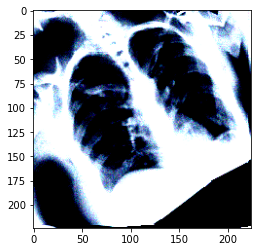

In [11]:
plt.imshow(x.numpy())

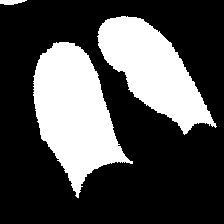

In [12]:
Image.fromarray(y.numpy().astype('bool'))

In [141]:
len(lung_data_1)

138

### Spliting the dataset

In [13]:
from sklearn.model_selection import ShuffleSplit

In [14]:
sss = ShuffleSplit(n_splits=1, test_size=0.1, random_state=0)

In [15]:
indices=range(len(lung_data_1))
for train_index, val_index in sss.split(indices):
    print(len(train_index))
    print("-"*10)
    print(len(val_index))

124
----------
14


In [16]:
from torch.utils.data import Subset
train_ds=Subset(lung_data_1,train_index)
print(len(train_ds))
print("-"*10)

val_ds=Subset(lung_data_2,val_index)
print(len(val_ds))

124
----------
14


In [17]:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False)

In [18]:
for img_b, mask_b in train_dl:
    print(img_b.shape,img_b.dtype)
    print(mask_b.shape, mask_b.dtype)
    break

torch.Size([8, 224, 224, 3]) torch.float32
torch.Size([8, 224, 224]) torch.float32


### Model

In [4]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )

class ResNetUNet(nn.Module):

    def __init__(self, n_classes=1):
        super().__init__()
        
        self.base_model = torchvision.models.resnet50(pretrained=False)
        
        self.base_layers = list(self.base_model.children())                
        
        self.layer0 = nn.Sequential(*self.base_layers[:3])
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5])        
        self.layer1_1x1 = convrelu(256, 256, 1, 0)       
        self.layer2 = self.base_layers[5]         
        self.layer2_1x1 = convrelu(512, 512, 1, 0)  
        self.layer3 = self.base_layers[6]         
        self.layer3_1x1 = convrelu(1024, 1024, 1, 0)  
        self.layer4 = self.base_layers[7] 
        self.layer4_1x1 = convrelu(2048, 2048, 1, 0)  
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv_up3 = convrelu(1024 + 2048, 1024, 3, 1)
        self.conv_up2 = convrelu(512 + 1024, 512, 3, 1)
        self.conv_up1 = convrelu(256 + 512, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 64, 3, 1)
        
        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(128, 64, 3, 1)
        
        self.conv_last = nn.Conv2d(64, n_classes, 1)
        
    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)
        
        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2) 
        layer4 = self.layer4(layer3)
        
        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)
        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)
        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)
        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)
        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)
        
        out = torch.sigmoid(self.conv_last(x))  

        return out

In [5]:
model = ResNetUNet().to('cuda');

In [21]:
def jaccard_coef_metric(inputs, target, eps=1e-7):
    intersection = (target * inputs).sum()
    union = (target.sum() + inputs.sum()) - intersection + eps

    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return (intersection + eps) / union

def dice_coef_metric(inputs, target):
    intersection = 2.0 * (target * inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return intersection / union

## Loss

def dice_coef_loss(inputs, target):
    smooth = 1.0
    intersection = 2.0 * ((target * inputs).sum()) + smooth
    union = target.sum() + inputs.sum() + smooth

    return 1 - (intersection / union)


def bce_dice_loss(inputs, target):
    dicescore = dice_coef_loss(inputs, target)
    bcescore = nn.BCELoss()
    bceloss = bcescore(inputs, target)

    return bceloss + dicescore

In [19]:
def train_one_epoch(model, optimizer, lr_scheduler, metric,
                    dataloader, epoch, criterion=bce_dice_loss):
    
    print("Start Train ...")
    model.train()

    losses = []
    accur = []

    for data, target in tqdm(dataloader):

        data = data.permute(0,3,1,2).to(DEVICE).float()
        targets = target.unsqueeze(1).to(DEVICE)

        outputs = model(data)

        out_cut = np.copy(outputs.data.cpu().numpy())
        out_cut[np.nonzero(out_cut < 0.5)] = 0.0
        out_cut[np.nonzero(out_cut >= 0.5)] = 1.0

        train_dice = metric(out_cut, targets.data.cpu().numpy())

        loss = criterion(outputs, targets)

        losses.append(loss.item())
        accur.append(train_dice)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if lr_scheduler is not None:
        lr_scheduler.step()

    lr = lr_scheduler.get_last_lr()[0]
    print("Epoch [%d]" % (epoch),
          "Mean loss on train:", np.array(losses).mean(), 
          "Mean DICE on train:", np.array(accur).mean(), 
          "Learning Rate:", lr)

    
    return np.array(losses).mean(), np.array(accur).mean(), lr


def val_epoch(model, metric, dataloader, epoch, threshold=0.5):
    
    print("Start Validation ...")
    model.eval()
    
    val_acc = []

    with torch.no_grad():
        for data, targets in tqdm(dataloader):

            data = data.permute(0,3,1,2).to(DEVICE).float()
            targets = targets.unsqueeze(1).to(DEVICE)

            outputs = model(data)

            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < threshold)] = 0.0
            out_cut[np.nonzero(out_cut >= threshold)] = 1.0

            val_dice = metric(out_cut, targets.data.cpu().numpy())
            val_acc.append(val_dice)

        print("Epoch:  " + str(epoch) + "  Threshold:  " + str(threshold)\
              + " Mean Validation DICE Score:", np.array(val_acc).mean())
        
        return  np.array(val_acc).mean()

In [181]:
for param in model.parameters():
    param.requires_grad = True
    
params = [p for p in model.parameters() if p.requires_grad]

stage_epoch =  [30, 10, 60] #[12, 8, 5]
stage_optimizer = [
    torch.optim.Adamax(params, lr=0.0002),
    torch.optim.SGD(params, lr=0.00009, momentum=0.9),
    torch.optim.Adam(params, lr=0.00005),
]

stage_scheduler = [
    torch.optim.lr_scheduler.CosineAnnealingLR(stage_optimizer[0], 4, 1e-6),
    torch.optim.lr_scheduler.CyclicLR(stage_optimizer[1], base_lr=1e-5, max_lr=2e-4),
    torch.optim.lr_scheduler.CosineAnnealingLR(stage_optimizer[2], 4, 1e-6),
]

In [182]:
DEVICE = 'cuda'
weights_dir = "weights"
if os.path.exists(weights_dir) == False:
    os.mkdir(weights_dir)


loss_history = []
train_dice_history = []
val_dice_history = []
lr_history = []

for k, (num_epochs, optimizer, lr_scheduler) in enumerate(zip(stage_epoch, stage_optimizer, stage_scheduler)):
    for epoch in range(num_epochs):
        
        
        loss, train_dice, lr = train_one_epoch(model, optimizer, lr_scheduler, 
                                               dice_coef_metric, train_dl, epoch)
    
        val_dice = val_epoch(model, dice_coef_metric, val_dl, epoch)
        
        
        # train history
        loss_history.append(loss)
        train_dice_history.append(train_dice)
        lr_history.append(lr)
        val_dice_history.append(val_dice)

        # save best weights
        best_dice = max(val_dice_history)
        if val_dice >= best_dice:
            torch.save({'state_dict': model.state_dict()},
                        os.path.join(weights_dir, f"{val_dice:0.6f}_.pth"))
    
    print("\nNext stage\n")
    # Load the best weights
    best_weights =  sorted(glob.glob(weights_dir + "/*"),
                       key= lambda x: x[8:-5])[-1]
    checkpoint = torch.load(best_weights)
    model.load_state_dict(checkpoint['state_dict'])

    print(f'Loaded model: {best_weights.split("/")[1]}')

Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [0] Mean loss on train: 0.19387991726398468 Mean DICE on train: 0.9342538788268815 Learning Rate: 0.0001708571247280615
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  0  Threshold:  0.5 Mean Validation DICE Score: 0.9690150359368336
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [1] Mean loss on train: 0.18392439745366573 Mean DICE on train: 0.9380220137386973 Learning Rate: 0.0001005
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  1  Threshold:  0.5 Mean Validation DICE Score: 0.9683243176443493
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [2] Mean loss on train: 0.17257605213671923 Mean DICE on train: 0.940666560110936 Learning Rate: 3.014287527193853e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  2  Threshold:  0.5 Mean Validation DICE Score: 0.974049961804645
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [3] Mean loss on train: 0.14904512465000153 Mean DICE on train: 0.9487032831786059 Learning Rate: 1e-06
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  3  Threshold:  0.5 Mean Validation DICE Score: 0.9749440969175465
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [4] Mean loss on train: 0.15904479380697012 Mean DICE on train: 0.9460887711115704 Learning Rate: 3.014287527193852e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  4  Threshold:  0.5 Mean Validation DICE Score: 0.9748507471140666
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [5] Mean loss on train: 0.14697457943111658 Mean DICE on train: 0.9506328219932652 Learning Rate: 0.00010050000000000002
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  5  Threshold:  0.5 Mean Validation DICE Score: 0.9742118882090031
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [6] Mean loss on train: 0.1539367800578475 Mean DICE on train: 0.9492947861896548 Learning Rate: 0.00017085712472806155
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  6  Threshold:  0.5 Mean Validation DICE Score: 0.9751059972305101
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [7] Mean loss on train: 0.13888729037716985 Mean DICE on train: 0.9518372973085392 Learning Rate: 0.0002000000000000001
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  7  Threshold:  0.5 Mean Validation DICE Score: 0.974736341019727
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [8] Mean loss on train: 0.1596123706549406 Mean DICE on train: 0.9464118679788676 Learning Rate: 0.00017085712472806157
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  8  Threshold:  0.5 Mean Validation DICE Score: 0.9754502502422391
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [9] Mean loss on train: 0.15645506465807557 Mean DICE on train: 0.9472703193657133 Learning Rate: 0.00010050000000000007
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  9  Threshold:  0.5 Mean Validation DICE Score: 0.9744883308465415
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [10] Mean loss on train: 0.13765470404177904 Mean DICE on train: 0.9542819777227546 Learning Rate: 3.014287527193862e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  10  Threshold:  0.5 Mean Validation DICE Score: 0.9743908038158723
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [11] Mean loss on train: 0.14757292298600078 Mean DICE on train: 0.949980687987704 Learning Rate: 1e-06
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  11  Threshold:  0.5 Mean Validation DICE Score: 0.9749368531165219
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [12] Mean loss on train: 0.14022636227309704 Mean DICE on train: 0.9526809485677936 Learning Rate: 3.014287527193852e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  12  Threshold:  0.5 Mean Validation DICE Score: 0.9750055284958522
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [13] Mean loss on train: 0.15880079939961433 Mean DICE on train: 0.946463417347366 Learning Rate: 0.0001004999999999998
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  13  Threshold:  0.5 Mean Validation DICE Score: 0.9756814287054062
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [14] Mean loss on train: 0.1376654622144997 Mean DICE on train: 0.9527370647126823 Learning Rate: 0.0001708571247280611
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  14  Threshold:  0.5 Mean Validation DICE Score: 0.974573581577713
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [15] Mean loss on train: 0.1310628936626017 Mean DICE on train: 0.9534783466499044 Learning Rate: 0.00019999999999999968
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  15  Threshold:  0.5 Mean Validation DICE Score: 0.9763218658494676
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [16] Mean loss on train: 0.14033863972872496 Mean DICE on train: 0.9519482462453819 Learning Rate: 0.0001708571247280612
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  16  Threshold:  0.5 Mean Validation DICE Score: 0.9758401699550252
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [17] Mean loss on train: 0.13610221352428198 Mean DICE on train: 0.9528753624109534 Learning Rate: 0.0001004999999999999
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  17  Threshold:  0.5 Mean Validation DICE Score: 0.9755032646121755
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [18] Mean loss on train: 0.14309702813625336 Mean DICE on train: 0.9513705454257726 Learning Rate: 3.0142875271938587e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  18  Threshold:  0.5 Mean Validation DICE Score: 0.9755466388358847
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [19] Mean loss on train: 0.1319237039424479 Mean DICE on train: 0.954445081362395 Learning Rate: 1e-06
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  19  Threshold:  0.5 Mean Validation DICE Score: 0.9764343856592546
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [20] Mean loss on train: 0.1294493325985968 Mean DICE on train: 0.955957762186707 Learning Rate: 3.014287527193852e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  20  Threshold:  0.5 Mean Validation DICE Score: 0.9765295933059696
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [21] Mean loss on train: 0.13665135437622666 Mean DICE on train: 0.9530669541600955 Learning Rate: 0.00010049999999999969
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  21  Threshold:  0.5 Mean Validation DICE Score: 0.9768389856730434
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [22] Mean loss on train: 0.13284238427877426 Mean DICE on train: 0.9543749544706444 Learning Rate: 0.00017085712472806125
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  22  Threshold:  0.5 Mean Validation DICE Score: 0.9766356199152446
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [23] Mean loss on train: 0.12966435588896275 Mean DICE on train: 0.9553730861411134 Learning Rate: 0.00019999999999999985
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  23  Threshold:  0.5 Mean Validation DICE Score: 0.9757383283778576
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [24] Mean loss on train: 0.13671148428693414 Mean DICE on train: 0.9531821984376024 Learning Rate: 0.00017085712472806133
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  24  Threshold:  0.5 Mean Validation DICE Score: 0.9732036846340406
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [25] Mean loss on train: 0.13593747094273567 Mean DICE on train: 0.9537580434559042 Learning Rate: 0.00010049999999999981
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  25  Threshold:  0.5 Mean Validation DICE Score: 0.9762668523613284
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [26] Mean loss on train: 0.146524575073272 Mean DICE on train: 0.9493815326728525 Learning Rate: 3.0142875271938614e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  26  Threshold:  0.5 Mean Validation DICE Score: 0.9758992643408404
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [27] Mean loss on train: 0.1288330485112965 Mean DICE on train: 0.9554704280223902 Learning Rate: 1e-06
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  27  Threshold:  0.5 Mean Validation DICE Score: 0.9770714518206133
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [28] Mean loss on train: 0.12384125590324402 Mean DICE on train: 0.9574365724335542 Learning Rate: 3.014287527193852e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  28  Threshold:  0.5 Mean Validation DICE Score: 0.9769372223951113
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [29] Mean loss on train: 0.13853268837556243 Mean DICE on train: 0.9532769665904791 Learning Rate: 0.00010049999999999973
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  29  Threshold:  0.5 Mean Validation DICE Score: 0.9766514211134433

Next stage

Loaded model: 0.977071_.pth
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [0] Mean loss on train: 0.16975990450009704 Mean DICE on train: 0.9452195915358126 Learning Rate: 1.0095000000000033e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  0  Threshold:  0.5 Mean Validation DICE Score: 0.9769645778726344
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [1] Mean loss on train: 0.1298419302329421 Mean DICE on train: 0.9564268464449664 Learning Rate: 1.018999999999998e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  1  Threshold:  0.5 Mean Validation DICE Score: 0.9767735613400588
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [2] Mean loss on train: 0.14354293188080192 Mean DICE on train: 0.9495447453377606 Learning Rate: 1.028500000000001e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  2  Threshold:  0.5 Mean Validation DICE Score: 0.976601431548428
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [3] Mean loss on train: 0.1301362686790526 Mean DICE on train: 0.9566450077902258 Learning Rate: 1.0379999999999958e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  3  Threshold:  0.5 Mean Validation DICE Score: 0.9767919537140513
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [4] Mean loss on train: 0.13390755327418447 Mean DICE on train: 0.9544194873018519 Learning Rate: 1.047499999999999e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  4  Threshold:  0.5 Mean Validation DICE Score: 0.9768217262705028
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [5] Mean loss on train: 0.1229719347320497 Mean DICE on train: 0.9579745410926654 Learning Rate: 1.0570000000000022e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  5  Threshold:  0.5 Mean Validation DICE Score: 0.9766828304445181
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [6] Mean loss on train: 0.12818192737177014 Mean DICE on train: 0.9568880448550005 Learning Rate: 1.066499999999997e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  6  Threshold:  0.5 Mean Validation DICE Score: 0.9769251887051444
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [7] Mean loss on train: 0.14302497450262308 Mean DICE on train: 0.9506848960695722 Learning Rate: 1.0760000000000002e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  7  Threshold:  0.5 Mean Validation DICE Score: 0.9768420100411597
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [8] Mean loss on train: 0.12674698885530233 Mean DICE on train: 0.9561183885159936 Learning Rate: 1.0855000000000034e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  8  Threshold:  0.5 Mean Validation DICE Score: 0.976919315126965
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [9] Mean loss on train: 0.13559922901913524 Mean DICE on train: 0.9539729077871151 Learning Rate: 1.094999999999998e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  9  Threshold:  0.5 Mean Validation DICE Score: 0.977078052185512

Next stage

Loaded model: 0.977078_.pth
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [0] Mean loss on train: 0.16479346388950944 Mean DICE on train: 0.9472270325020047 Learning Rate: 4.2824116139070415e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  0  Threshold:  0.5 Mean Validation DICE Score: 0.9763022434253953
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [1] Mean loss on train: 0.13739752769470215 Mean DICE on train: 0.954147396394152 Learning Rate: 2.5500000000000003e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  1  Threshold:  0.5 Mean Validation DICE Score: 0.9751366282607526
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [2] Mean loss on train: 0.15524970646947622 Mean DICE on train: 0.9477779229595062 Learning Rate: 8.175883860929588e-06
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  2  Threshold:  0.5 Mean Validation DICE Score: 0.9738868410610879
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [3] Mean loss on train: 0.13651248114183545 Mean DICE on train: 0.9544591392231361 Learning Rate: 1e-06
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  3  Threshold:  0.5 Mean Validation DICE Score: 0.9751833098842712
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [4] Mean loss on train: 0.1463424782268703 Mean DICE on train: 0.9513713399076797 Learning Rate: 8.175883860929586e-06
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  4  Threshold:  0.5 Mean Validation DICE Score: 0.9757315961791609
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [5] Mean loss on train: 0.13453763537108898 Mean DICE on train: 0.9542417240667462 Learning Rate: 2.550000000000001e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  5  Threshold:  0.5 Mean Validation DICE Score: 0.9767255056669448
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [6] Mean loss on train: 0.13373737270012498 Mean DICE on train: 0.9544768968240691 Learning Rate: 4.2824116139070436e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  6  Threshold:  0.5 Mean Validation DICE Score: 0.9766551551778979
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [7] Mean loss on train: 0.12580436002463102 Mean DICE on train: 0.956992235287762 Learning Rate: 5.000000000000003e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  7  Threshold:  0.5 Mean Validation DICE Score: 0.9757898542267414
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [8] Mean loss on train: 0.13126074336469173 Mean DICE on train: 0.9562891081359035 Learning Rate: 4.282411613907044e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  8  Threshold:  0.5 Mean Validation DICE Score: 0.9732579191870991
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [9] Mean loss on train: 0.13392759999260306 Mean DICE on train: 0.9545317098974355 Learning Rate: 2.5500000000000024e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  9  Threshold:  0.5 Mean Validation DICE Score: 0.9759748197900713
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [10] Mean loss on train: 0.13676964957267046 Mean DICE on train: 0.9529361499831455 Learning Rate: 8.175883860929611e-06
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  10  Threshold:  0.5 Mean Validation DICE Score: 0.9752605153334287
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [11] Mean loss on train: 0.13580289809033275 Mean DICE on train: 0.9538123141926632 Learning Rate: 1e-06
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  11  Threshold:  0.5 Mean Validation DICE Score: 0.9769754883944475
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [12] Mean loss on train: 0.12434931099414825 Mean DICE on train: 0.9575085656350908 Learning Rate: 8.175883860929586e-06
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  12  Threshold:  0.5 Mean Validation DICE Score: 0.9770166665251611
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [13] Mean loss on train: 0.13195607718080282 Mean DICE on train: 0.9536822303646219 Learning Rate: 2.5499999999999956e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  13  Threshold:  0.5 Mean Validation DICE Score: 0.9775399431692502
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [14] Mean loss on train: 0.13430760940536857 Mean DICE on train: 0.9553828548329809 Learning Rate: 4.282411613907033e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  14  Threshold:  0.5 Mean Validation DICE Score: 0.9760360852303107
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [15] Mean loss on train: 0.13095926120877266 Mean DICE on train: 0.9556420990180609 Learning Rate: 4.999999999999993e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  15  Threshold:  0.5 Mean Validation DICE Score: 0.9753752200147332
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [16] Mean loss on train: 0.12558592995628715 Mean DICE on train: 0.9562702274973106 Learning Rate: 4.282411613907035e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  16  Threshold:  0.5 Mean Validation DICE Score: 0.9768431806572451
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [17] Mean loss on train: 0.12441185675561428 Mean DICE on train: 0.9576351279748847 Learning Rate: 2.5499999999999976e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  17  Threshold:  0.5 Mean Validation DICE Score: 0.9762716479377379
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [18] Mean loss on train: 0.13793853530660272 Mean DICE on train: 0.9523190076439958 Learning Rate: 8.175883860929601e-06
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  18  Threshold:  0.5 Mean Validation DICE Score: 0.9769025193656103
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [19] Mean loss on train: 0.12451504776254296 Mean DICE on train: 0.9585116916002069 Learning Rate: 1e-06
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  19  Threshold:  0.5 Mean Validation DICE Score: 0.9773392414621199
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [20] Mean loss on train: 0.1296289162710309 Mean DICE on train: 0.9550246259066786 Learning Rate: 8.175883860929586e-06
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  20  Threshold:  0.5 Mean Validation DICE Score: 0.9775835154542616
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [21] Mean loss on train: 0.13573100976645947 Mean DICE on train: 0.9549408341150973 Learning Rate: 2.549999999999993e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  21  Threshold:  0.5 Mean Validation DICE Score: 0.9776974934100439
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [22] Mean loss on train: 0.1422406188212335 Mean DICE on train: 0.9535694362124307 Learning Rate: 4.282411613907036e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  22  Threshold:  0.5 Mean Validation DICE Score: 0.9771238588147262
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [23] Mean loss on train: 0.12067104270681739 Mean DICE on train: 0.9596057399918986 Learning Rate: 4.999999999999997e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  23  Threshold:  0.5 Mean Validation DICE Score: 0.9766787645987205
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [24] Mean loss on train: 0.12115800566971302 Mean DICE on train: 0.9582236609244044 Learning Rate: 4.282411613907039e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  24  Threshold:  0.5 Mean Validation DICE Score: 0.9760572532934991
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [25] Mean loss on train: 0.14616559725254774 Mean DICE on train: 0.9522237668361346 Learning Rate: 2.5499999999999966e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  25  Threshold:  0.5 Mean Validation DICE Score: 0.9731492875060339
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [26] Mean loss on train: 0.14457730948925018 Mean DICE on train: 0.9524690602496227 Learning Rate: 8.175883860929611e-06
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  26  Threshold:  0.5 Mean Validation DICE Score: 0.9763170886522322
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [27] Mean loss on train: 0.12673014122992754 Mean DICE on train: 0.9561918555170139 Learning Rate: 1e-06
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  27  Threshold:  0.5 Mean Validation DICE Score: 0.9766261869848094
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [28] Mean loss on train: 0.1223988295532763 Mean DICE on train: 0.9578742529228299 Learning Rate: 8.175883860929586e-06
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  28  Threshold:  0.5 Mean Validation DICE Score: 0.9767338635102645
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [29] Mean loss on train: 0.12101828726008534 Mean DICE on train: 0.9596056275559068 Learning Rate: 2.5499999999999942e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  29  Threshold:  0.5 Mean Validation DICE Score: 0.9776475688295645
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [30] Mean loss on train: 0.12045997427776456 Mean DICE on train: 0.9587488741028775 Learning Rate: 4.282411613907039e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  30  Threshold:  0.5 Mean Validation DICE Score: 0.9766993338183478
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [31] Mean loss on train: 0.13646296504884958 Mean DICE on train: 0.9529729109233007 Learning Rate: 5.000000000000001e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  31  Threshold:  0.5 Mean Validation DICE Score: 0.9754255432736346
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [32] Mean loss on train: 0.12269141804426908 Mean DICE on train: 0.9589189247797307 Learning Rate: 4.282411613907042e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  32  Threshold:  0.5 Mean Validation DICE Score: 0.977085164671042
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [33] Mean loss on train: 0.12306491238996387 Mean DICE on train: 0.9584520568084746 Learning Rate: 2.549999999999999e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  33  Threshold:  0.5 Mean Validation DICE Score: 0.9760688720677678
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [34] Mean loss on train: 0.12389121111482382 Mean DICE on train: 0.9565540328160091 Learning Rate: 8.175883860929621e-06
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  34  Threshold:  0.5 Mean Validation DICE Score: 0.9764368468877783
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [35] Mean loss on train: 0.14011522009968758 Mean DICE on train: 0.952225375497858 Learning Rate: 1e-06
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  35  Threshold:  0.5 Mean Validation DICE Score: 0.976968244051237
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [36] Mean loss on train: 0.12221209658309817 Mean DICE on train: 0.958463537183499 Learning Rate: 8.175883860929586e-06
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  36  Threshold:  0.5 Mean Validation DICE Score: 0.9768960449449656
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [37] Mean loss on train: 0.12985210306942463 Mean DICE on train: 0.9539046989441726 Learning Rate: 2.5499999999999946e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  37  Threshold:  0.5 Mean Validation DICE Score: 0.9765672179206205
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [38] Mean loss on train: 0.11989565240219235 Mean DICE on train: 0.9575925736940608 Learning Rate: 4.28241161390704e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  38  Threshold:  0.5 Mean Validation DICE Score: 0.9730351158874636
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [39] Mean loss on train: 0.14150184160098433 Mean DICE on train: 0.9499954007377445 Learning Rate: 5.000000000000002e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  39  Threshold:  0.5 Mean Validation DICE Score: 0.9753805460897086
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [40] Mean loss on train: 0.15588022815063596 Mean DICE on train: 0.9475305116093728 Learning Rate: 4.2824116139070504e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  40  Threshold:  0.5 Mean Validation DICE Score: 0.9741727790901556
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [41] Mean loss on train: 0.13710710918530822 Mean DICE on train: 0.9523641374680644 Learning Rate: 2.5500000000000003e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  41  Threshold:  0.5 Mean Validation DICE Score: 0.9740555766087295
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [42] Mean loss on train: 0.14685424463823438 Mean DICE on train: 0.9496888301798204 Learning Rate: 8.175883860929627e-06
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  42  Threshold:  0.5 Mean Validation DICE Score: 0.9749199694687796
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [43] Mean loss on train: 0.1454450311139226 Mean DICE on train: 0.9502740277142782 Learning Rate: 1e-06
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  43  Threshold:  0.5 Mean Validation DICE Score: 0.9746337634912524
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [44] Mean loss on train: 0.12351977033540606 Mean DICE on train: 0.9579898430167579 Learning Rate: 8.175883860929586e-06
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  44  Threshold:  0.5 Mean Validation DICE Score: 0.9748949125519784
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [45] Mean loss on train: 0.1403456423431635 Mean DICE on train: 0.9536208558609403 Learning Rate: 2.5499999999999956e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  45  Threshold:  0.5 Mean Validation DICE Score: 0.9755783587908552
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [46] Mean loss on train: 0.13595411833375692 Mean DICE on train: 0.9537394633562607 Learning Rate: 4.282411613907049e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  46  Threshold:  0.5 Mean Validation DICE Score: 0.9748880658736189
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [47] Mean loss on train: 0.14006620598956943 Mean DICE on train: 0.9530231491243981 Learning Rate: 5.000000000000006e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  47  Threshold:  0.5 Mean Validation DICE Score: 0.9736259900808953
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [48] Mean loss on train: 0.13746919436380267 Mean DICE on train: 0.9522206061078513 Learning Rate: 4.2824116139070544e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  48  Threshold:  0.5 Mean Validation DICE Score: 0.9750938598073834
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [49] Mean loss on train: 0.14481081813573837 Mean DICE on train: 0.9504402691016218 Learning Rate: 2.5500000000000027e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  49  Threshold:  0.5 Mean Validation DICE Score: 0.9732054733064154
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [50] Mean loss on train: 0.14348830841481686 Mean DICE on train: 0.9508592454074263 Learning Rate: 8.175883860929637e-06
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  50  Threshold:  0.5 Mean Validation DICE Score: 0.9767755155178952
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [51] Mean loss on train: 0.13264150405302644 Mean DICE on train: 0.9554313198332768 Learning Rate: 1e-06
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  51  Threshold:  0.5 Mean Validation DICE Score: 0.9765732763494109
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [52] Mean loss on train: 0.12600344000384212 Mean DICE on train: 0.9568693256920187 Learning Rate: 8.175883860929586e-06
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  52  Threshold:  0.5 Mean Validation DICE Score: 0.9766147528697762
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [53] Mean loss on train: 0.1196000799536705 Mean DICE on train: 0.9593842065370959 Learning Rate: 2.549999999999996e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  53  Threshold:  0.5 Mean Validation DICE Score: 0.9774026974079065
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [54] Mean loss on train: 0.11742754001170397 Mean DICE on train: 0.9596245961828155 Learning Rate: 4.2824116139070504e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  54  Threshold:  0.5 Mean Validation DICE Score: 0.9767590371318533
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [55] Mean loss on train: 0.1367828929796815 Mean DICE on train: 0.9548976917495706 Learning Rate: 5.000000000000008e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  55  Threshold:  0.5 Mean Validation DICE Score: 0.9757324593581721
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [56] Mean loss on train: 0.11604797327890992 Mean DICE on train: 0.959799945070639 Learning Rate: 4.282411613907055e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  56  Threshold:  0.5 Mean Validation DICE Score: 0.976393754985498
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [57] Mean loss on train: 0.14022303372621536 Mean DICE on train: 0.9539878252893788 Learning Rate: 2.5500000000000037e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  57  Threshold:  0.5 Mean Validation DICE Score: 0.9768013580800654
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [58] Mean loss on train: 0.13626590138301253 Mean DICE on train: 0.9540511922871028 Learning Rate: 8.175883860929643e-06
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  58  Threshold:  0.5 Mean Validation DICE Score: 0.9759726858103804
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [59] Mean loss on train: 0.11985956225544214 Mean DICE on train: 0.9588951742039761 Learning Rate: 1e-06
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  59  Threshold:  0.5 Mean Validation DICE Score: 0.9771350422713504

Next stage

Loaded model: 0.977697_.pth


In [170]:
df_logs = pd.DataFrame(
    {'loss': loss_history,
     "lr" : lr_history,
     'train_dice':train_dice_history,
     'val_dice': val_dice_history
    })
df_logs.to_csv("train_logs_9210.csv", index=False)

### Inference

In [6]:
model.load_state_dict(state_dict=torch.load("/media/brats/DRIVE1/akansh/lung-seg/notebook/weights/0.977697_.pth")['state_dict'])

<All keys matched successfully>

In [7]:
from skimage.segmentation import mark_boundaries
from scipy import ndimage as ndi
import warnings
warnings.filterwarnings('ignore')

In [66]:
model.eval()
threshold = 0.5
DEVICE = 'cuda'
with torch.no_grad():
    for data_batch,mask in val_dl:

        data_batch = data_batch.permute(0,3,1,2).to(DEVICE).float()

        outputs = model(data_batch)


        out_cut = np.copy(outputs.data.cpu().numpy())
        out_cut[np.nonzero(out_cut < threshold)] = 0.0
        out_cut[np.nonzero(out_cut >= threshold)] = 1.0
        
#         for image, mask in zip(data_batch.data.cpu().numpy(), out_cut):

#             result = add_colored_mask(image.transpose(1, 2, 0), mask.transpose(1, 2, 0))
            
        break

In [30]:
def show_img_mask(img, mask):    
    img_mask = mark_boundaries(np.array(img),mask.astype('bool'),outline_color=(0,1,0),color=(0,1,0))
    plt.imshow(img_mask)

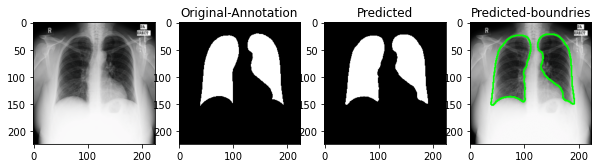

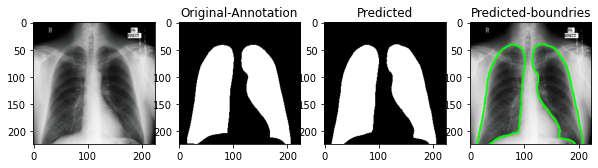

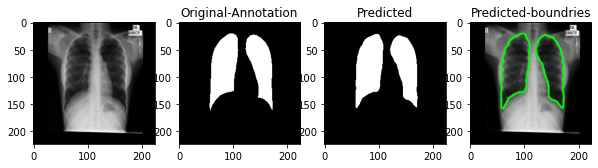

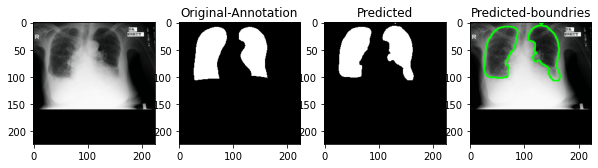

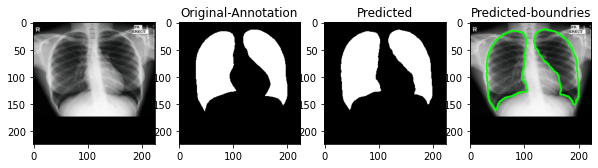

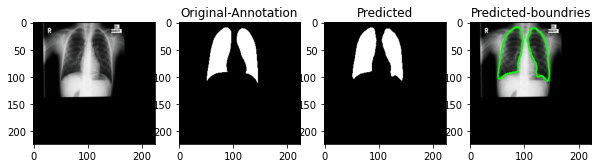

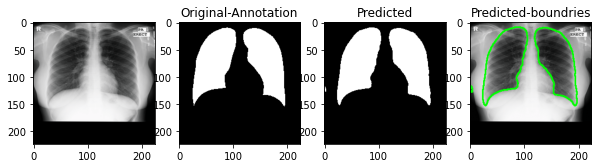

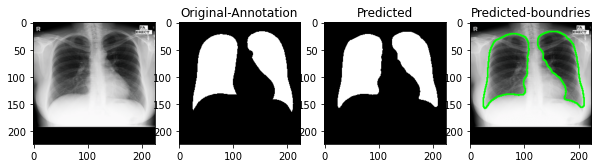

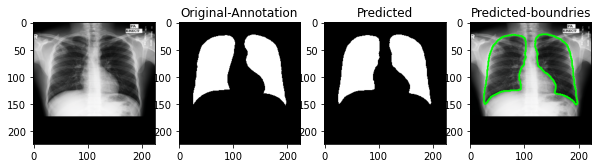

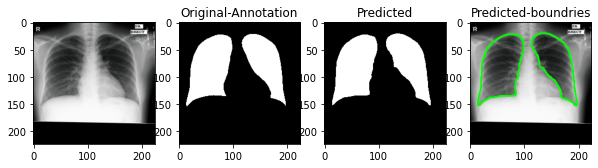

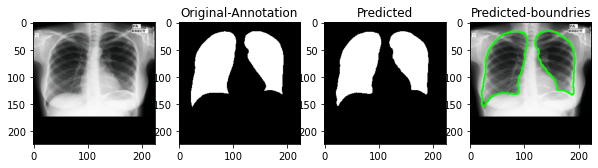

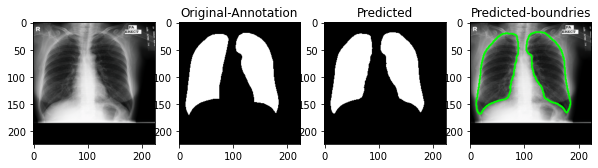

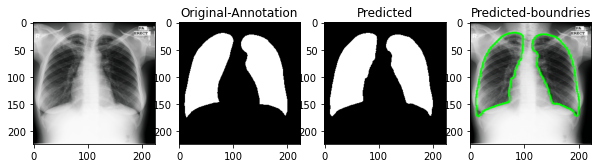

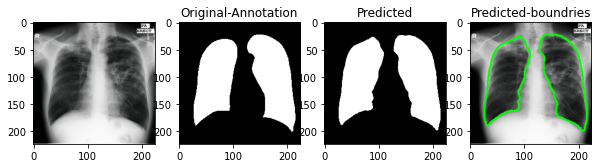

In [88]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

for i in range(0,len(data_batch)):
    img = (((data_batch.permute(0,2,3,1)[i].cpu().numpy()*std)+mean)*255).astype('uint8')
    annt_edges = mask[i].cpu().numpy()
#     mask = ndi.binary_fill_holes(annt_edges)
    plt.figure(figsize=(10,15))
    plt.subplot(1, 4, 1)
    plt.imshow(img, cmap="gray")
    plt.subplot(1, 4, 2)
    plt.imshow(annt_edges, cmap="gray")
    plt.title("Original-Annotation")
    plt.subplot(1, 4, 3)
    plt.imshow(out_cut[i][0], cmap="gray")
    plt.title("Predicted")
    plt.subplot(1, 4, 4)
    show_img_mask(img, out_cut[i][0])
    plt.title("Predicted-boundries")
    

### Test

In [45]:
def lung_seg(img_path, back = False, plot = True):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224,224), interpolation = cv2.INTER_LANCZOS4)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resized = np.copy(img)
    
    norm = A.Normalize()
    img = norm(image = img)['image']
    DEVICE = 'cuda'
    model.eval()
    with torch.no_grad():
        out = model(torch.unsqueeze(torch.tensor(img), dim = 0).permute(0,3,1,2).to(DEVICE).float())
        out_2 = np.copy(out.data.cpu().numpy())
        out_2[np.nonzero(out_2 < 0.5)] = 0.0
        out_2[np.nonzero(out_2 >= 0.5)] = 1.0
        
    if plot == True:
        plt.figure(figsize=(10,15))
        plt.subplot(1, 3, 1)
        plt.imshow(resized, cmap="gray")

        plt.subplot(1, 3, 2)
        plt.imshow(out_2[0][0], cmap="gray")

        plt.subplot(1, 3, 3)
        show_img_mask(resized,out_2[0][0])
    
    if back == True:
        return resized, out_2[0][0]

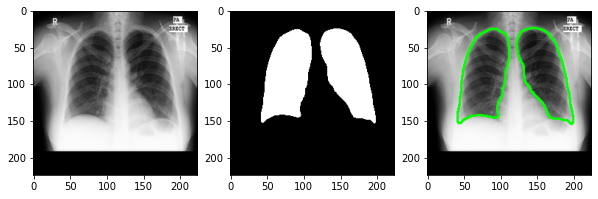

In [42]:
lung_seg(os.path.join(path2img, test_image_name))

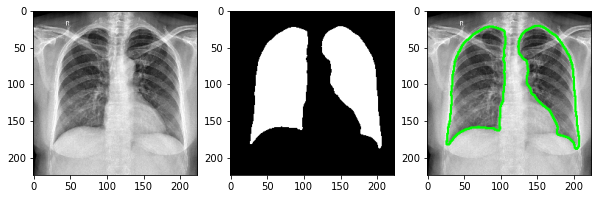

In [46]:
orig, mask = lung_seg("/media/brats/mirlproject2/vinbigdata-chest-xray-abnormalities-detection/vinbig_png/0b80aaae33916b6c56b4308584cd67c0.png", back = True)

In [50]:
cv2.imwrite("A.png", mask*255)

True